This notebook runs first.
After that run notebook test_kafka_producer_consumer.ipynb

## Prerequisite

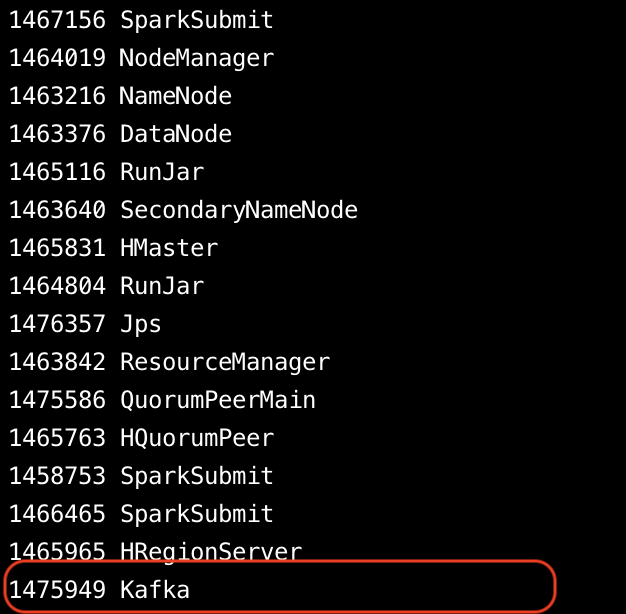



`bin/zookeeper-server-start.sh config/zookeeper.properties`

<br>

`bin/kafka-server-start.sh config/server.properties`

In [30]:
from __future__ import unicode_literals

import json
from time import sleep
from bs4 import BeautifulSoup

In [31]:
from kafka import KafkaConsumer, KafkaProducer

import requests
# -*- coding: utf-8 -*-


In [32]:
def fetch_raw(recipe_url):
    html = None
    print('Processing..{}'.format(recipe_url))
    try:
        r = requests.get(recipe_url, headers=headers)
        if r.status_code == 200:
            html = r.text
             
    except Exception as ex:
        print('Exception while accessing raw html')
        print(str(ex))
    finally:
        return html.strip()

def get_recipes(url):
    recipes = []
    print('Accessing list')

    try:
        r = requests.get(url, headers=headers)
       
        if r.status_code == 200:
            soup = BeautifulSoup(r.text, 'html.parser')
            
            # Find the script tag with the schema data
            script = soup.find('script', {'id': 'allrecipes-schema_1-0', 'type': 'application/ld+json'})
            
            if script:
                # Parse the JSON-LD data
                data = json.loads(script.string)
                recipe_urls = [item['url'] for item in data[0]['itemListElement']]
                
                print(f'Found {len(recipe_urls)} recipes in schema')
                
                # Limit to first 3 recipes for testing
                for recipe_url in recipe_urls[:3]:
                    sleep(2)  # Be polite with delays
                    try:
                        recipe = fetch_raw(recipe_url)
                        recipes.append(recipe)
                        
                        print(f'Fetched recipe from: {recipe_url}')
                    except Exception as e:
                        print(f'Error fetching {recipe_url}: {str(e)}')
            else:
                print('No schema data found, falling back to HTML scraping')
                links = soup.select('.card__titleLink')
                print(f'Found {len(links)} recipes in HTML')
                for link in links[:3]:  # Limit to first 3
                    sleep(2)
                    try:
                        recipe = fetch_raw(link['href'])
                        recipes.append(recipe)
                    except Exception as e:
                        print(f'Error fetching {link["href"]}: {str(e)}')

    except Exception as ex:
        print('Exception in get_recipes:', str(ex))
    
    return recipes




def get_recipes(url):
    recipies = []
    salad_url = 'https://www.allrecipes.com/recipes/156/bread/'
    #url = 'https://www.allrecipes.com/recipes/156/bread/'
    #url = 'https://www.allrecipes.com/recipes/23014/world-cuisine/asian/thai/desserts'
    
    print('Accessing list')

    try:
        r = requests.get(url, headers=headers)
       
        if r.status_code == 200:
            html = r.text
            print(html)
            #soup = BeautifulSoup(html, 'lxml')
            soup = BeautifulSoup(html, 'html.parser')
            #soup = BeautifulSoup(r.content, features="html")
            links = soup.select('.card__titleLink')
             
            idx = 0
            print('total',len(links))
            for link in links:

                sleep(2)
                #print(link)
                recipe = fetch_raw(link['href'])
                #print(recipe)
                recipies.append(recipe)
                
                #print(link['href'])
                idx += 1
                if idx > 3:
                    break
    except Exception as ex:
        print('Exception in get_recipes')
        print(str(ex))
    finally:
        return recipies

In [33]:
def publish_message(producer_instance, topic_name, key, value):
    try:
        #print(key)
        #print(value)
        key_bytes =  bytes(key, encoding='utf-8')   #.encode('utf-8')
        value_bytes = bytes(value, encoding='utf-8') #encode('utf-8')
        
        producer_instance.send(topic_name, key=key_bytes, value=value_bytes)
        #print(value_bytes)
        producer_instance.flush()
        print('Message published successfully.')
    except Exception as ex:
        print('Exception in publishing message')
        print(str(ex))


def connect_kafka_producer():
    _producer = None
    try:
        _producer = KafkaProducer(bootstrap_servers=['localhost:9092'], api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _producer

In [34]:
if __name__ == '__main__':
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.181 Safari/537.36',
        'Pragma': 'no-cache'
    }
    url =  'https://www.allrecipes.com/recipes/702/world-cuisine/asian/thai/'
    all_recipes = get_recipes(url)
    #print( all_recipes )
    
     
    if len(all_recipes) > 0:
        kafka_producer = connect_kafka_producer()
        for count, recipe in enumerate(all_recipes, start=1):
             
            publish_message(kafka_producer, 'raw_recipes', 'raw', recipe.strip())
            if count > 3:
                break
        if kafka_producer is not None:
            kafka_producer.close()

Accessing list
Found 63 recipes in schema
Processing..https://www.allrecipes.com/thai-chopped-chicken-bean-salad-recipe-11689687
Fetched recipe from: https://www.allrecipes.com/thai-chopped-chicken-bean-salad-recipe-11689687
Processing..https://www.allrecipes.com/thai-peanut-butter-ramen-recipe-8775397
Fetched recipe from: https://www.allrecipes.com/thai-peanut-butter-ramen-recipe-8775397
Processing..https://www.allrecipes.com/recipe/240476/turkey-tom-kha-gai/
Fetched recipe from: https://www.allrecipes.com/recipe/240476/turkey-tom-kha-gai/
Message published successfully.
Message published successfully.
Message published successfully.


At this point, your jps should have

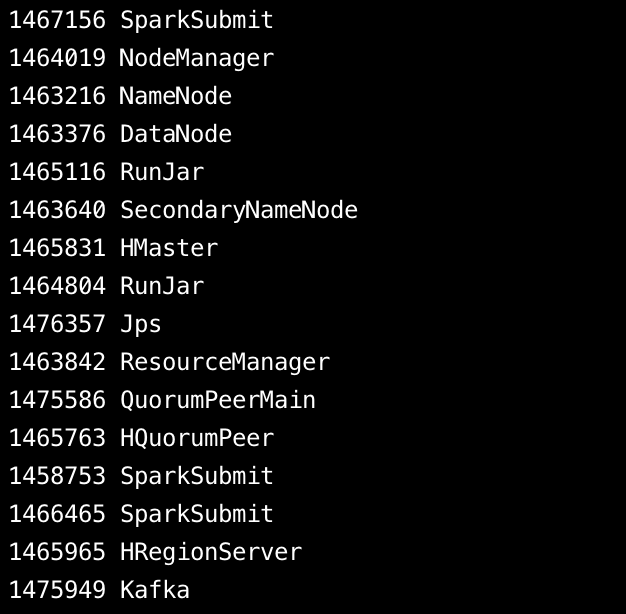